# Computer Vision: Assignment 3 Part 1 - Some CNN Basics [50%]

Spring 2022 semester.

Due date: **July 1st 2022.**

## Introduction

This question is an introduction to using PyTorch for training simple neural net models. 

Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

Perform this assignment in PyTorch, modifying the baseline code, producing outputs and adding required explanations - *all within this ipython notebook*.

Finally, submit this iPython notebook, including outputs, as an .ipynb file. 

## Question (1): Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

**a)**  Use `matplotlib` and ipython notebook's visualization capabilities to display the average train and average test image of each class, for each of the two datasets.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

## Question (2): Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST. By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 10 epochs (passes through the training data). 

The cross-entropy loss function computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given target.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

**a)** Add code to plot out the network weights as images (one for each class, of size 28 by 28) after the last epoch. (Hint thread: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) )

**b)** Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Question (3): Training a Multi-Layer Network on MNIST [10%]

**a)**  Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class].

**b)**   Now retrain the model for 10 epochs with each of the learning rates in the set {0.01, 0.1, 1, 10} and test the resulting model. Create a figure and plot the loss curves of each of the four runs for comparison. Explain the obtained (train and test) results.

## Question (4): Training a Convolutional Network on CIFAR [15%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, stride 2, 16 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

**a)** Train it for 20 epochs on CIFAR-10 and plot the training loss curve (avg. loss per epoch) and final test loss and accuracy, when training with or without the two 3x3 convolutional layers. 

**b)**  Give a breakdown of the number of parameters (per layer) within the above model, as well as the overall number.

# **Answer (1):**
create needed blocks of code (and results) below

In [13]:
# imports
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

import matplotlib
from matplotlib.ticker import MaxNLocator

In [14]:
def imshow(img1, img2, dataset, label):
    img1 = img1 / 2 + 0.5  # un-normalize
    img2 = img2 / 2 + 0.5
    np_img1, np_img2 = img1.numpy(), img2.numpy()

    plt.figure()
    plt.suptitle(dataset + " dataset average: Class " + label)
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(np_img1, (1, 2, 0)))
    plt.title('Train')
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(np_img2, (1, 2, 0)))
    plt.title('Test')
    plt.show()

In [15]:
def show_average_images(train_loader, test_loader, dataset, labels):
    '''Plots the average image for each class in the dataset both for the training data and the test one'''
    
    train_counters, test_counters = [], []
    train_results, test_results = [], []
    
    for _ in range(len(labels)):
        train_counters.append(0)
        test_counters.append(0)
        train_results.append(None)
        test_results.append(None)
    
    dataiter = iter(train_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            mn_value = torch.min(img_temp)
            mx_value = torch.max(img_temp)
            
            img_temp -= mn_value
            
            img_temp /= (mx_value - mn_value)
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    train_counters[ind] += 1
                    if train_results[ind] is None:
                        train_results[ind] = img_temp
                    else:
                        train_results[ind] += img_temp

        except StopIteration:
            break

    dataiter = iter(test_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            mn_value = torch.min(img_temp)
            mx_value = torch.max(img_temp)
            
            img_temp -= mn_value
            
            img_temp /= (mx_value - mn_value)
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    test_counters[ind] += 1
                    if test_results[ind] is None:
                        test_results[ind] = img_temp
                    else:
                        test_results[ind] += img_temp

        except StopIteration:
            break
    
    for index, label in enumerate(labels):
        
        test_results[index] /= test_counters[index]
        train_results[index] /= train_counters[index]

        imshow(torchvision.utils.make_grid(train_results[index]), torchvision.utils.make_grid(test_results[index]), 
               dataset, labels[index])

Files already downloaded and verified
Files already downloaded and verified


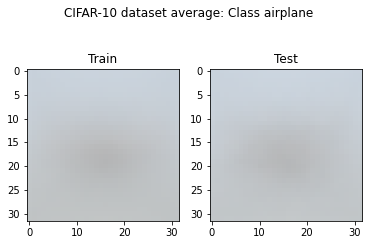

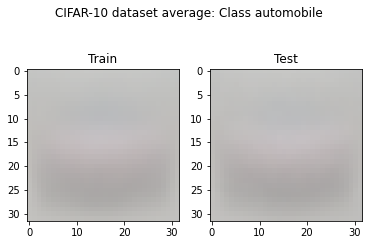

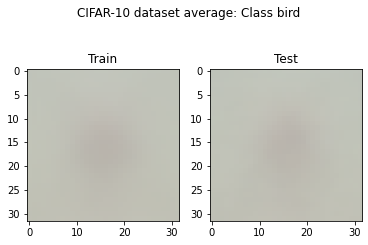

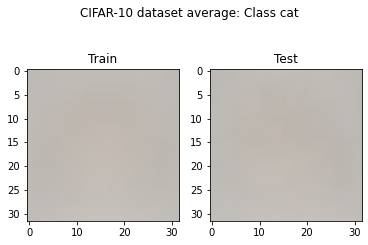

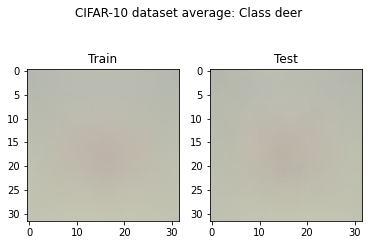

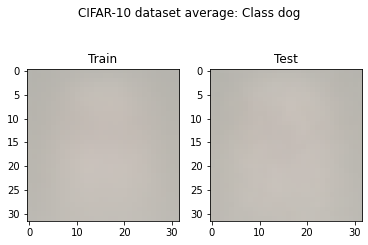

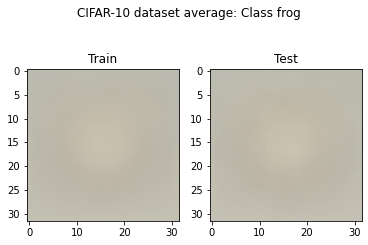

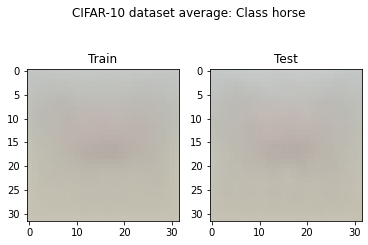

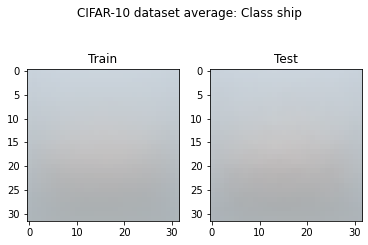

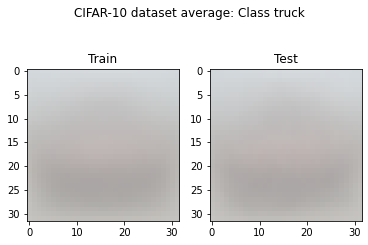

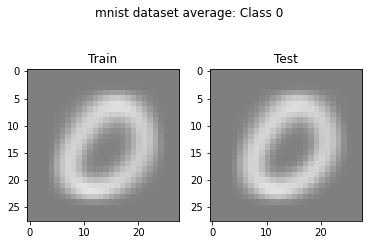

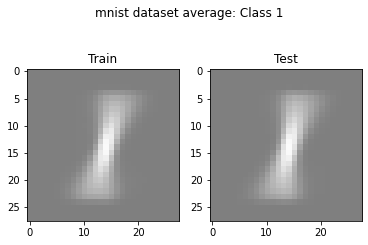

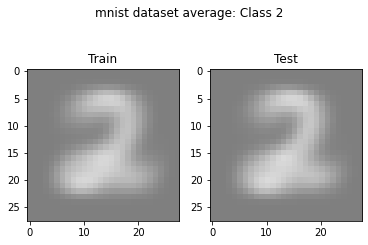

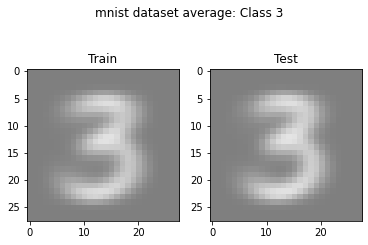

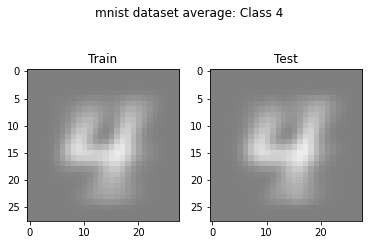

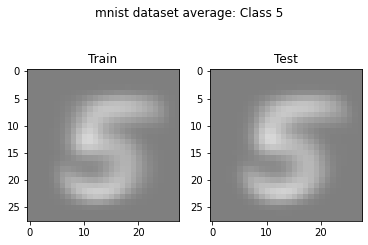

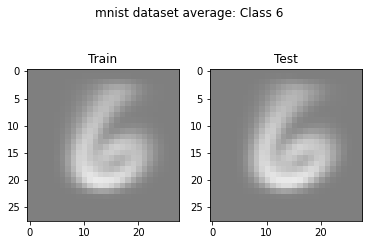

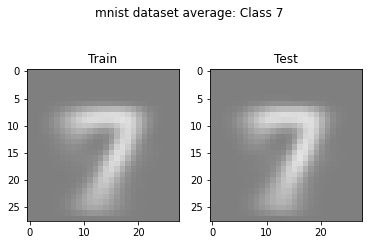

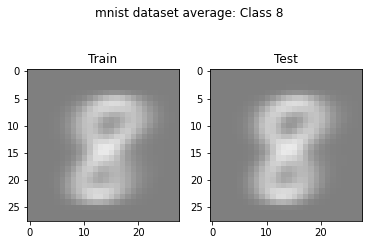

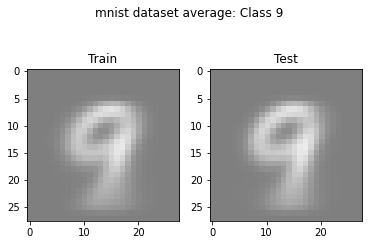

In [16]:
torch.utils.data.DataLoader.num_worker = 0

# building the transforms and data loaders

cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

cifar_train = torchvision.datasets.CIFAR10(root='.', train=True,
                                           download=True, transform=cifar_transform)

cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

cifar_test = torchvision.datasets.CIFAR10(root='.', train=False,
                                          download=True, transform=cifar_transform)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=1,
                                                shuffle=False, num_workers=2)

mnist_train = torchvision.datasets.MNIST(root='.', train=True,
                                         download=True, transform=mnist_transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

mnist_test = torchvision.datasets.MNIST(root='.', train=False,
                                        download=True, transform=mnist_transform)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1,
                                                shuffle=False, num_workers=2)

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

show_average_images(cifar_train_loader, cifar_test_loader, 'CIFAR-10', cifar_labels)
show_average_images(mnist_train_loader, mnist_test_loader, 'mnist', mnist_labels)

# **Answer (2):**
create needed blocks of code (and results) below

In [17]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [18]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [19]:
# train and test functions
def train(epoch, train_loader):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [20]:
# Training and testing 
for i in range(1, epochs+1):
  train(i, mnist_train_loader)

# resetting the value of batch size in the DataLoader objects
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.814571
Train Epoch: 1 [100/60000 (0%)]	Loss: 0.208839
Train Epoch: 1 [200/60000 (0%)]	Loss: 0.088510
Train Epoch: 1 [300/60000 (0%)]	Loss: 0.989360
Train Epoch: 1 [400/60000 (1%)]	Loss: 3.146794
Train Epoch: 1 [500/60000 (1%)]	Loss: 0.006079
Train Epoch: 1 [600/60000 (1%)]	Loss: 0.062516
Train Epoch: 1 [700/60000 (1%)]	Loss: 0.004845
Train Epoch: 1 [800/60000 (1%)]	Loss: 0.066764
Train Epoch: 1 [900/60000 (2%)]	Loss: 0.029231
Train Epoch: 1 [1000/60000 (2%)]	Loss: 0.844654
Train Epoch: 1 [1100/60000 (2%)]	Loss: 8.958284
Train Epoch: 1 [1200/60000 (2%)]	Loss: 0.003025
Train Epoch: 1 [1300/60000 (2%)]	Loss: 0.000001
Train Epoch: 1 [1400/60000 (2%)]	Loss: 0.000220
Train Epoch: 1 [1500/60000 (2%)]	Loss: 0.000306
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.000091
Train Epoch: 1 [1700/60000 (3%)]	Loss: 0.000000
Train Epoch: 1 [1800/60000 (3%)]	Loss: 0.002520
Train Epoch: 1 [1900/60000 (3%)]	Loss: 0.000152
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.000001
Trai

Train Epoch: 1 [16900/60000 (28%)]	Loss: 0.000000
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.000000
Train Epoch: 1 [17100/60000 (28%)]	Loss: 0.079599
Train Epoch: 1 [17200/60000 (29%)]	Loss: 0.000000
Train Epoch: 1 [17300/60000 (29%)]	Loss: 0.000015
Train Epoch: 1 [17400/60000 (29%)]	Loss: 0.000039
Train Epoch: 1 [17500/60000 (29%)]	Loss: 0.373212
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.000591
Train Epoch: 1 [17700/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [17800/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [17900/60000 (30%)]	Loss: 0.000001
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.000159
Train Epoch: 1 [18100/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [18200/60000 (30%)]	Loss: 0.000001
Train Epoch: 1 [18300/60000 (30%)]	Loss: 0.000529
Train Epoch: 1 [18400/60000 (31%)]	Loss: 0.000045
Train Epoch: 1 [18500/60000 (31%)]	Loss: 3.710083
Train Epoch: 1 [18600/60000 (31%)]	Loss: 0.000021
Train Epoch: 1 [18700/60000 (31%)]	Loss: 0.000000
Train Epoch: 1 [18800/60000 (31%)]	Loss: 0.000264


Train Epoch: 1 [33700/60000 (56%)]	Loss: 0.000000
Train Epoch: 1 [33800/60000 (56%)]	Loss: 0.001091
Train Epoch: 1 [33900/60000 (56%)]	Loss: 0.000006
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.738938
Train Epoch: 1 [34100/60000 (57%)]	Loss: 0.002348
Train Epoch: 1 [34200/60000 (57%)]	Loss: 0.005310
Train Epoch: 1 [34300/60000 (57%)]	Loss: 4.923232
Train Epoch: 1 [34400/60000 (57%)]	Loss: 0.000014
Train Epoch: 1 [34500/60000 (58%)]	Loss: 0.000002
Train Epoch: 1 [34600/60000 (58%)]	Loss: 0.000094
Train Epoch: 1 [34700/60000 (58%)]	Loss: 0.000677
Train Epoch: 1 [34800/60000 (58%)]	Loss: 12.647598
Train Epoch: 1 [34900/60000 (58%)]	Loss: 0.000033
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.000023
Train Epoch: 1 [35100/60000 (58%)]	Loss: 0.026929
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.001903
Train Epoch: 1 [35300/60000 (59%)]	Loss: 0.001177
Train Epoch: 1 [35400/60000 (59%)]	Loss: 0.000046
Train Epoch: 1 [35500/60000 (59%)]	Loss: 0.030563
Train Epoch: 1 [35600/60000 (59%)]	Loss: 0.000001

Train Epoch: 1 [50100/60000 (84%)]	Loss: 0.049136
Train Epoch: 1 [50200/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50300/60000 (84%)]	Loss: 0.034100
Train Epoch: 1 [50400/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50500/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50600/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50700/60000 (84%)]	Loss: 0.003596
Train Epoch: 1 [50800/60000 (85%)]	Loss: 0.000044
Train Epoch: 1 [50900/60000 (85%)]	Loss: 7.112521
Train Epoch: 1 [51000/60000 (85%)]	Loss: 5.748295
Train Epoch: 1 [51100/60000 (85%)]	Loss: 0.000064
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000000
Train Epoch: 1 [51300/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51400/60000 (86%)]	Loss: 0.002689
Train Epoch: 1 [51500/60000 (86%)]	Loss: 0.000011
Train Epoch: 1 [51600/60000 (86%)]	Loss: 0.901843
Train Epoch: 1 [51700/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51800/60000 (86%)]	Loss: 0.000009
Train Epoch: 1 [51900/60000 (86%)]	Loss: 0.000023
Train Epoch: 1 [52000/60000 (87%)]	Loss: 0.172286


Train Epoch: 2 [7200/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7300/60000 (12%)]	Loss: 0.025345
Train Epoch: 2 [7400/60000 (12%)]	Loss: 0.000914
Train Epoch: 2 [7500/60000 (12%)]	Loss: 0.002962
Train Epoch: 2 [7600/60000 (13%)]	Loss: 0.000693
Train Epoch: 2 [7700/60000 (13%)]	Loss: 0.000303
Train Epoch: 2 [7800/60000 (13%)]	Loss: 0.000000
Train Epoch: 2 [7900/60000 (13%)]	Loss: 0.001020
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.000001
Train Epoch: 2 [8100/60000 (14%)]	Loss: 0.000483
Train Epoch: 2 [8200/60000 (14%)]	Loss: 0.000009
Train Epoch: 2 [8300/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8400/60000 (14%)]	Loss: 0.000166
Train Epoch: 2 [8500/60000 (14%)]	Loss: 1.746822
Train Epoch: 2 [8600/60000 (14%)]	Loss: 21.617111
Train Epoch: 2 [8700/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8800/60000 (15%)]	Loss: 0.521521
Train Epoch: 2 [8900/60000 (15%)]	Loss: 0.038333
Train Epoch: 2 [9000/60000 (15%)]	Loss: 2.236032
Train Epoch: 2 [9100/60000 (15%)]	Loss: 0.020503
Train Epoch: 2 [920

Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.002141
Train Epoch: 2 [24100/60000 (40%)]	Loss: 0.001730
Train Epoch: 2 [24200/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24300/60000 (40%)]	Loss: 0.000075
Train Epoch: 2 [24400/60000 (41%)]	Loss: 0.000001
Train Epoch: 2 [24500/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24600/60000 (41%)]	Loss: 0.000410
Train Epoch: 2 [24700/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24800/60000 (41%)]	Loss: 0.000003
Train Epoch: 2 [24900/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.873841
Train Epoch: 2 [25100/60000 (42%)]	Loss: 0.094603
Train Epoch: 2 [25200/60000 (42%)]	Loss: 0.013626
Train Epoch: 2 [25300/60000 (42%)]	Loss: 0.000015
Train Epoch: 2 [25400/60000 (42%)]	Loss: 0.000003
Train Epoch: 2 [25500/60000 (42%)]	Loss: 0.008625
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.335821
Train Epoch: 2 [25700/60000 (43%)]	Loss: 0.031247
Train Epoch: 2 [25800/60000 (43%)]	Loss: 0.549940
Train Epoch: 2 [25900/60000 (43%)]	Loss: 0.000012


Train Epoch: 2 [40700/60000 (68%)]	Loss: 0.079459
Train Epoch: 2 [40800/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [40900/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [41000/60000 (68%)]	Loss: 0.007642
Train Epoch: 2 [41100/60000 (68%)]	Loss: 0.021460
Train Epoch: 2 [41200/60000 (69%)]	Loss: 0.000003
Train Epoch: 2 [41300/60000 (69%)]	Loss: 0.001645
Train Epoch: 2 [41400/60000 (69%)]	Loss: 2.396313
Train Epoch: 2 [41500/60000 (69%)]	Loss: 0.000001
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41700/60000 (70%)]	Loss: 0.006434
Train Epoch: 2 [41800/60000 (70%)]	Loss: 0.047566
Train Epoch: 2 [41900/60000 (70%)]	Loss: 1.862090
Train Epoch: 2 [42000/60000 (70%)]	Loss: 16.265783
Train Epoch: 2 [42100/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [42200/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [42300/60000 (70%)]	Loss: 3.024057
Train Epoch: 2 [42400/60000 (71%)]	Loss: 1.811033
Train Epoch: 2 [42500/60000 (71%)]	Loss: 6.251155
Train Epoch: 2 [42600/60000 (71%)]	Loss: 0.026078

Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.032938
Train Epoch: 2 [57700/60000 (96%)]	Loss: 4.327309
Train Epoch: 2 [57800/60000 (96%)]	Loss: 0.000123
Train Epoch: 2 [57900/60000 (96%)]	Loss: 0.470378
Train Epoch: 2 [58000/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58100/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58200/60000 (97%)]	Loss: 2.366813
Train Epoch: 2 [58300/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58400/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58500/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [58600/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [58700/60000 (98%)]	Loss: 0.000001
Train Epoch: 2 [58800/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [58900/60000 (98%)]	Loss: 9.312284
Train Epoch: 2 [59000/60000 (98%)]	Loss: 0.001417
Train Epoch: 2 [59100/60000 (98%)]	Loss: 0.000259
Train Epoch: 2 [59200/60000 (99%)]	Loss: 0.111321
Train Epoch: 2 [59300/60000 (99%)]	Loss: 0.000000
Train Epoch: 2 [59400/60000 (99%)]	Loss: 0.000000
Train Epoch: 2 [59500/60000 (99%)]	Loss: 0.000003


Train Epoch: 3 [14700/60000 (24%)]	Loss: 0.000424
Train Epoch: 3 [14800/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [14900/60000 (25%)]	Loss: 0.000001
Train Epoch: 3 [15000/60000 (25%)]	Loss: 0.000001
Train Epoch: 3 [15100/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [15200/60000 (25%)]	Loss: 0.004383
Train Epoch: 3 [15300/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15400/60000 (26%)]	Loss: 0.005679
Train Epoch: 3 [15500/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15600/60000 (26%)]	Loss: 0.000008
Train Epoch: 3 [15700/60000 (26%)]	Loss: 0.000168
Train Epoch: 3 [15800/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15900/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.034877
Train Epoch: 3 [16100/60000 (27%)]	Loss: 0.000001
Train Epoch: 3 [16200/60000 (27%)]	Loss: 0.000601
Train Epoch: 3 [16300/60000 (27%)]	Loss: 0.000778
Train Epoch: 3 [16400/60000 (27%)]	Loss: 0.000048
Train Epoch: 3 [16500/60000 (28%)]	Loss: 0.172063
Train Epoch: 3 [16600/60000 (28%)]	Loss: 0.000000


Train Epoch: 3 [31500/60000 (52%)]	Loss: 0.004946
Train Epoch: 3 [31600/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31700/60000 (53%)]	Loss: 0.000040
Train Epoch: 3 [31800/60000 (53%)]	Loss: 0.001020
Train Epoch: 3 [31900/60000 (53%)]	Loss: 0.000031
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [32100/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32200/60000 (54%)]	Loss: 0.000053
Train Epoch: 3 [32300/60000 (54%)]	Loss: 0.000010
Train Epoch: 3 [32400/60000 (54%)]	Loss: 0.642707
Train Epoch: 3 [32500/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32600/60000 (54%)]	Loss: 0.000089
Train Epoch: 3 [32700/60000 (54%)]	Loss: 0.000002
Train Epoch: 3 [32800/60000 (55%)]	Loss: 0.125086
Train Epoch: 3 [32900/60000 (55%)]	Loss: 0.000003
Train Epoch: 3 [33000/60000 (55%)]	Loss: 13.267392
Train Epoch: 3 [33100/60000 (55%)]	Loss: 0.000000
Train Epoch: 3 [33200/60000 (55%)]	Loss: 0.000019
Train Epoch: 3 [33300/60000 (56%)]	Loss: 0.000018
Train Epoch: 3 [33400/60000 (56%)]	Loss: 0.011035

Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.000068
Train Epoch: 3 [48100/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48200/60000 (80%)]	Loss: 0.000003
Train Epoch: 3 [48300/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48400/60000 (81%)]	Loss: 0.000000
Train Epoch: 3 [48500/60000 (81%)]	Loss: 0.000006
Train Epoch: 3 [48600/60000 (81%)]	Loss: 1.353710
Train Epoch: 3 [48700/60000 (81%)]	Loss: 0.000001
Train Epoch: 3 [48800/60000 (81%)]	Loss: 0.000005
Train Epoch: 3 [48900/60000 (82%)]	Loss: 7.212929
Train Epoch: 3 [49000/60000 (82%)]	Loss: 0.000023
Train Epoch: 3 [49100/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49200/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49300/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49400/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49500/60000 (82%)]	Loss: 0.000428
Train Epoch: 3 [49600/60000 (83%)]	Loss: 0.000100
Train Epoch: 3 [49700/60000 (83%)]	Loss: 1.992831
Train Epoch: 3 [49800/60000 (83%)]	Loss: 0.000029
Train Epoch: 3 [49900/60000 (83%)]	Loss: 0.000005


Train Epoch: 4 [4600/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [4700/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [4800/60000 (8%)]	Loss: 0.000001
Train Epoch: 4 [4900/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [5000/60000 (8%)]	Loss: 0.000045
Train Epoch: 4 [5100/60000 (8%)]	Loss: 0.000262
Train Epoch: 4 [5200/60000 (9%)]	Loss: 0.015853
Train Epoch: 4 [5300/60000 (9%)]	Loss: 0.000001
Train Epoch: 4 [5400/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5500/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5600/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5700/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [5800/60000 (10%)]	Loss: 0.000667
Train Epoch: 4 [5900/60000 (10%)]	Loss: 0.000058
Train Epoch: 4 [6000/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [6100/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [6200/60000 (10%)]	Loss: 0.000001
Train Epoch: 4 [6300/60000 (10%)]	Loss: 0.001441
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.002024
Train Epoch: 4 [6500/60000 (11%)]	Loss: 0.000116
Train Epoch: 4 [6600/60000 (11%

Train Epoch: 4 [21700/60000 (36%)]	Loss: 0.298543
Train Epoch: 4 [21800/60000 (36%)]	Loss: 0.000001
Train Epoch: 4 [21900/60000 (36%)]	Loss: 0.000000
Train Epoch: 4 [22000/60000 (37%)]	Loss: 0.000573
Train Epoch: 4 [22100/60000 (37%)]	Loss: 0.000002
Train Epoch: 4 [22200/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22300/60000 (37%)]	Loss: 0.000010
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.000001
Train Epoch: 4 [22500/60000 (38%)]	Loss: 0.000000
Train Epoch: 4 [22600/60000 (38%)]	Loss: 0.000011
Train Epoch: 4 [22700/60000 (38%)]	Loss: 0.000000
Train Epoch: 4 [22800/60000 (38%)]	Loss: 3.559197
Train Epoch: 4 [22900/60000 (38%)]	Loss: 0.000000
Train Epoch: 4 [23000/60000 (38%)]	Loss: 14.351510
Train Epoch: 4 [23100/60000 (38%)]	Loss: 0.009323
Train Epoch: 4 [23200/60000 (39%)]	Loss: 0.003291
Train Epoch: 4 [23300/60000 (39%)]	Loss: 0.000000
Train Epoch: 4 [23400/60000 (39%)]	Loss: 0.000003
Train Epoch: 4 [23500/60000 (39%)]	Loss: 0.000575
Train Epoch: 4 [23600/60000 (39%)]	Loss: 4.578393

Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38500/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38600/60000 (64%)]	Loss: 0.000002
Train Epoch: 4 [38700/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38800/60000 (65%)]	Loss: 10.992314
Train Epoch: 4 [38900/60000 (65%)]	Loss: 0.000000
Train Epoch: 4 [39000/60000 (65%)]	Loss: 0.000331
Train Epoch: 4 [39100/60000 (65%)]	Loss: 3.999710
Train Epoch: 4 [39200/60000 (65%)]	Loss: 0.000000
Train Epoch: 4 [39300/60000 (66%)]	Loss: 0.158360
Train Epoch: 4 [39400/60000 (66%)]	Loss: 0.000000
Train Epoch: 4 [39500/60000 (66%)]	Loss: 0.000000
Train Epoch: 4 [39600/60000 (66%)]	Loss: 0.000011
Train Epoch: 4 [39700/60000 (66%)]	Loss: 0.008452
Train Epoch: 4 [39800/60000 (66%)]	Loss: 0.000759
Train Epoch: 4 [39900/60000 (66%)]	Loss: 2.692526
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.550343
Train Epoch: 4 [40100/60000 (67%)]	Loss: 0.000008
Train Epoch: 4 [40200/60000 (67%)]	Loss: 0.000601
Train Epoch: 4 [40300/60000 (67%)]	Loss: 0.227565

Train Epoch: 4 [55100/60000 (92%)]	Loss: 0.000000
Train Epoch: 4 [55200/60000 (92%)]	Loss: 16.055996
Train Epoch: 4 [55300/60000 (92%)]	Loss: 0.000000
Train Epoch: 4 [55400/60000 (92%)]	Loss: 0.000029
Train Epoch: 4 [55500/60000 (92%)]	Loss: 0.003645
Train Epoch: 4 [55600/60000 (93%)]	Loss: 0.008281
Train Epoch: 4 [55700/60000 (93%)]	Loss: 0.245064
Train Epoch: 4 [55800/60000 (93%)]	Loss: 0.000018
Train Epoch: 4 [55900/60000 (93%)]	Loss: 0.000000
Train Epoch: 4 [56000/60000 (93%)]	Loss: 0.000041
Train Epoch: 4 [56100/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56200/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56300/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56400/60000 (94%)]	Loss: 0.000616
Train Epoch: 4 [56500/60000 (94%)]	Loss: 0.038064
Train Epoch: 4 [56600/60000 (94%)]	Loss: 0.000619
Train Epoch: 4 [56700/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56800/60000 (95%)]	Loss: 0.000000
Train Epoch: 4 [56900/60000 (95%)]	Loss: 0.000000
Train Epoch: 4 [57000/60000 (95%)]	Loss: 1.027195

Train Epoch: 5 [12300/60000 (20%)]	Loss: 0.000003
Train Epoch: 5 [12400/60000 (21%)]	Loss: 0.000044
Train Epoch: 5 [12500/60000 (21%)]	Loss: 7.869386
Train Epoch: 5 [12600/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12700/60000 (21%)]	Loss: 0.000065
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12900/60000 (22%)]	Loss: 0.003275
Train Epoch: 5 [13000/60000 (22%)]	Loss: 0.000004
Train Epoch: 5 [13100/60000 (22%)]	Loss: 0.000002
Train Epoch: 5 [13200/60000 (22%)]	Loss: 0.000295
Train Epoch: 5 [13300/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13400/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13500/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13600/60000 (23%)]	Loss: 0.000773
Train Epoch: 5 [13700/60000 (23%)]	Loss: 0.030774
Train Epoch: 5 [13800/60000 (23%)]	Loss: 0.000000
Train Epoch: 5 [13900/60000 (23%)]	Loss: 12.549805
Train Epoch: 5 [14000/60000 (23%)]	Loss: 0.020134
Train Epoch: 5 [14100/60000 (24%)]	Loss: 3.563583
Train Epoch: 5 [14200/60000 (24%)]	Loss: 0.000012

Train Epoch: 5 [29200/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29300/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29400/60000 (49%)]	Loss: 0.012284
Train Epoch: 5 [29500/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29600/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29700/60000 (50%)]	Loss: 11.041160
Train Epoch: 5 [29800/60000 (50%)]	Loss: 0.000008
Train Epoch: 5 [29900/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [30000/60000 (50%)]	Loss: 0.170383
Train Epoch: 5 [30100/60000 (50%)]	Loss: 0.000008
Train Epoch: 5 [30200/60000 (50%)]	Loss: 0.000002
Train Epoch: 5 [30300/60000 (50%)]	Loss: 0.038308
Train Epoch: 5 [30400/60000 (51%)]	Loss: 0.000000
Train Epoch: 5 [30500/60000 (51%)]	Loss: 0.000000
Train Epoch: 5 [30600/60000 (51%)]	Loss: 0.000000
Train Epoch: 5 [30700/60000 (51%)]	Loss: 0.000000
Train Epoch: 5 [30800/60000 (51%)]	Loss: 0.000000
Train Epoch: 5 [30900/60000 (52%)]	Loss: 0.000029
Train Epoch: 5 [31000/60000 (52%)]	Loss: 0.000007
Train Epoch: 5 [31100/60000 (52%)]	Loss: 0.000000

Train Epoch: 5 [45800/60000 (76%)]	Loss: 6.345705
Train Epoch: 5 [45900/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [46000/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46100/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46200/60000 (77%)]	Loss: 4.211991
Train Epoch: 5 [46300/60000 (77%)]	Loss: 0.000013
Train Epoch: 5 [46400/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46500/60000 (78%)]	Loss: 0.000005
Train Epoch: 5 [46600/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [46700/60000 (78%)]	Loss: 3.596336
Train Epoch: 5 [46800/60000 (78%)]	Loss: 0.000030
Train Epoch: 5 [46900/60000 (78%)]	Loss: 0.290836
Train Epoch: 5 [47000/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [47100/60000 (78%)]	Loss: 2.992310
Train Epoch: 5 [47200/60000 (79%)]	Loss: 0.000000
Train Epoch: 5 [47300/60000 (79%)]	Loss: 0.000000
Train Epoch: 5 [47400/60000 (79%)]	Loss: 0.000000
Train Epoch: 5 [47500/60000 (79%)]	Loss: 0.000000
Train Epoch: 5 [47600/60000 (79%)]	Loss: 0.000123
Train Epoch: 5 [47700/60000 (80%)]	Loss: 0.000000


Train Epoch: 6 [2300/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2400/60000 (4%)]	Loss: 0.048054
Train Epoch: 6 [2500/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2600/60000 (4%)]	Loss: 0.000004
Train Epoch: 6 [2700/60000 (4%)]	Loss: 0.000066
Train Epoch: 6 [2800/60000 (5%)]	Loss: 0.124025
Train Epoch: 6 [2900/60000 (5%)]	Loss: 0.000000
Train Epoch: 6 [3000/60000 (5%)]	Loss: 0.000000
Train Epoch: 6 [3100/60000 (5%)]	Loss: 0.000002
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.000022
Train Epoch: 6 [3300/60000 (6%)]	Loss: 0.000002
Train Epoch: 6 [3400/60000 (6%)]	Loss: 0.000227
Train Epoch: 6 [3500/60000 (6%)]	Loss: 1.431468
Train Epoch: 6 [3600/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [3700/60000 (6%)]	Loss: 0.000757
Train Epoch: 6 [3800/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [3900/60000 (6%)]	Loss: 0.000006
Train Epoch: 6 [4000/60000 (7%)]	Loss: 0.164381
Train Epoch: 6 [4100/60000 (7%)]	Loss: 0.897400
Train Epoch: 6 [4200/60000 (7%)]	Loss: 0.000011
Train Epoch: 6 [4300/60000 (7%)]	Loss: 0

Train Epoch: 6 [19300/60000 (32%)]	Loss: 0.000002
Train Epoch: 6 [19400/60000 (32%)]	Loss: 0.106943
Train Epoch: 6 [19500/60000 (32%)]	Loss: 5.860653
Train Epoch: 6 [19600/60000 (33%)]	Loss: 0.009322
Train Epoch: 6 [19700/60000 (33%)]	Loss: 0.460075
Train Epoch: 6 [19800/60000 (33%)]	Loss: 0.000000
Train Epoch: 6 [19900/60000 (33%)]	Loss: 0.000868
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.008195
Train Epoch: 6 [20100/60000 (34%)]	Loss: 0.025084
Train Epoch: 6 [20200/60000 (34%)]	Loss: 0.000001
Train Epoch: 6 [20300/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20400/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20500/60000 (34%)]	Loss: 0.000020
Train Epoch: 6 [20600/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20700/60000 (34%)]	Loss: 0.000016
Train Epoch: 6 [20800/60000 (35%)]	Loss: 0.000000
Train Epoch: 6 [20900/60000 (35%)]	Loss: 0.008255
Train Epoch: 6 [21000/60000 (35%)]	Loss: 0.011162
Train Epoch: 6 [21100/60000 (35%)]	Loss: 7.670899
Train Epoch: 6 [21200/60000 (35%)]	Loss: 0.000000


Train Epoch: 6 [36000/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36100/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36200/60000 (60%)]	Loss: 0.000537
Train Epoch: 6 [36300/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36400/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36500/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36600/60000 (61%)]	Loss: 0.041413
Train Epoch: 6 [36700/60000 (61%)]	Loss: 0.000769
Train Epoch: 6 [36800/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36900/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37000/60000 (62%)]	Loss: 0.000003
Train Epoch: 6 [37100/60000 (62%)]	Loss: 6.666180
Train Epoch: 6 [37200/60000 (62%)]	Loss: 0.050360
Train Epoch: 6 [37300/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37400/60000 (62%)]	Loss: 0.011441
Train Epoch: 6 [37500/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37600/60000 (63%)]	Loss: 0.274153
Train Epoch: 6 [37700/60000 (63%)]	Loss: 0.000000
Train Epoch: 6 [37800/60000 (63%)]	Loss: 0.000000
Train Epoch: 6 [37900/60000 (63%)]	Loss: 0.000002


Train Epoch: 6 [52900/60000 (88%)]	Loss: 0.001246
Train Epoch: 6 [53000/60000 (88%)]	Loss: 3.053020
Train Epoch: 6 [53100/60000 (88%)]	Loss: 0.000001
Train Epoch: 6 [53200/60000 (89%)]	Loss: 0.000000
Train Epoch: 6 [53300/60000 (89%)]	Loss: 0.015921
Train Epoch: 6 [53400/60000 (89%)]	Loss: 0.006742
Train Epoch: 6 [53500/60000 (89%)]	Loss: 0.000000
Train Epoch: 6 [53600/60000 (89%)]	Loss: 0.000000
Train Epoch: 6 [53700/60000 (90%)]	Loss: 0.003503
Train Epoch: 6 [53800/60000 (90%)]	Loss: 0.000000
Train Epoch: 6 [53900/60000 (90%)]	Loss: 0.000000
Train Epoch: 6 [54000/60000 (90%)]	Loss: 0.000097
Train Epoch: 6 [54100/60000 (90%)]	Loss: 0.000010
Train Epoch: 6 [54200/60000 (90%)]	Loss: 0.000020
Train Epoch: 6 [54300/60000 (90%)]	Loss: 0.000000
Train Epoch: 6 [54400/60000 (91%)]	Loss: 0.000000
Train Epoch: 6 [54500/60000 (91%)]	Loss: 0.000000
Train Epoch: 6 [54600/60000 (91%)]	Loss: 0.000000
Train Epoch: 6 [54700/60000 (91%)]	Loss: 4.814850
Train Epoch: 6 [54800/60000 (91%)]	Loss: 0.000002


Train Epoch: 7 [9700/60000 (16%)]	Loss: 0.153412
Train Epoch: 7 [9800/60000 (16%)]	Loss: 0.045433
Train Epoch: 7 [9900/60000 (16%)]	Loss: 0.000020
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10100/60000 (17%)]	Loss: 0.000080
Train Epoch: 7 [10200/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10300/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10400/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10500/60000 (18%)]	Loss: 5.993552
Train Epoch: 7 [10600/60000 (18%)]	Loss: 0.000050
Train Epoch: 7 [10700/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [10800/60000 (18%)]	Loss: 0.000001
Train Epoch: 7 [10900/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [11000/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [11100/60000 (18%)]	Loss: 0.026569
Train Epoch: 7 [11200/60000 (19%)]	Loss: 0.000090
Train Epoch: 7 [11300/60000 (19%)]	Loss: 0.000015
Train Epoch: 7 [11400/60000 (19%)]	Loss: 0.000000
Train Epoch: 7 [11500/60000 (19%)]	Loss: 0.000000
Train Epoch: 7 [11600/60000 (19%)]	Loss: 34.840721
Tr

Train Epoch: 7 [26500/60000 (44%)]	Loss: 0.000058
Train Epoch: 7 [26600/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26700/60000 (44%)]	Loss: 0.000034
Train Epoch: 7 [26800/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [26900/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [27000/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [27100/60000 (45%)]	Loss: 0.003952
Train Epoch: 7 [27200/60000 (45%)]	Loss: 0.002187
Train Epoch: 7 [27300/60000 (46%)]	Loss: 11.475259
Train Epoch: 7 [27400/60000 (46%)]	Loss: 9.889977
Train Epoch: 7 [27500/60000 (46%)]	Loss: 0.002243
Train Epoch: 7 [27600/60000 (46%)]	Loss: 5.942462
Train Epoch: 7 [27700/60000 (46%)]	Loss: 0.000009
Train Epoch: 7 [27800/60000 (46%)]	Loss: 12.179743
Train Epoch: 7 [27900/60000 (46%)]	Loss: 26.013588
Train Epoch: 7 [28000/60000 (47%)]	Loss: 0.000033
Train Epoch: 7 [28100/60000 (47%)]	Loss: 0.000000
Train Epoch: 7 [28200/60000 (47%)]	Loss: 0.130202
Train Epoch: 7 [28300/60000 (47%)]	Loss: 0.000099
Train Epoch: 7 [28400/60000 (47%)]	Loss: 1.0365

Train Epoch: 7 [43100/60000 (72%)]	Loss: 0.001020
Train Epoch: 7 [43200/60000 (72%)]	Loss: 0.000053
Train Epoch: 7 [43300/60000 (72%)]	Loss: 0.000012
Train Epoch: 7 [43400/60000 (72%)]	Loss: 16.183058
Train Epoch: 7 [43500/60000 (72%)]	Loss: 0.001828
Train Epoch: 7 [43600/60000 (73%)]	Loss: 0.000770
Train Epoch: 7 [43700/60000 (73%)]	Loss: 0.001106
Train Epoch: 7 [43800/60000 (73%)]	Loss: 0.000000
Train Epoch: 7 [43900/60000 (73%)]	Loss: 0.000000
Train Epoch: 7 [44000/60000 (73%)]	Loss: 0.000000
Train Epoch: 7 [44100/60000 (74%)]	Loss: 0.000008
Train Epoch: 7 [44200/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44300/60000 (74%)]	Loss: 0.032241
Train Epoch: 7 [44400/60000 (74%)]	Loss: 0.000361
Train Epoch: 7 [44500/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44600/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44700/60000 (74%)]	Loss: 0.000011
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.026687
Train Epoch: 7 [44900/60000 (75%)]	Loss: 0.000001
Train Epoch: 7 [45000/60000 (75%)]	Loss: 0.820876

Train Epoch: 7 [59500/60000 (99%)]	Loss: 0.002859
Train Epoch: 7 [59600/60000 (99%)]	Loss: 0.000000
Train Epoch: 7 [59700/60000 (100%)]	Loss: 0.000000
Train Epoch: 7 [59800/60000 (100%)]	Loss: 0.000015
Train Epoch: 7 [59900/60000 (100%)]	Loss: 0.000000
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000000
Train Epoch: 8 [100/60000 (0%)]	Loss: 0.000156
Train Epoch: 8 [200/60000 (0%)]	Loss: 0.000000
Train Epoch: 8 [300/60000 (0%)]	Loss: 0.007172
Train Epoch: 8 [400/60000 (1%)]	Loss: 5.983067
Train Epoch: 8 [500/60000 (1%)]	Loss: 0.078249
Train Epoch: 8 [600/60000 (1%)]	Loss: 0.000013
Train Epoch: 8 [700/60000 (1%)]	Loss: 0.000000
Train Epoch: 8 [800/60000 (1%)]	Loss: 0.002074
Train Epoch: 8 [900/60000 (2%)]	Loss: 0.000000
Train Epoch: 8 [1000/60000 (2%)]	Loss: 0.000000
Train Epoch: 8 [1100/60000 (2%)]	Loss: 8.955932
Train Epoch: 8 [1200/60000 (2%)]	Loss: 0.000000
Train Epoch: 8 [1300/60000 (2%)]	Loss: 0.001472
Train Epoch: 8 [1400/60000 (2%)]	Loss: 0.000000
Train Epoch: 8 [1500/60000 (2%)]	Loss: 

Train Epoch: 8 [16400/60000 (27%)]	Loss: 0.000039
Train Epoch: 8 [16500/60000 (28%)]	Loss: 0.008274
Train Epoch: 8 [16600/60000 (28%)]	Loss: 6.973787
Train Epoch: 8 [16700/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [16800/60000 (28%)]	Loss: 0.000001
Train Epoch: 8 [16900/60000 (28%)]	Loss: 0.000008
Train Epoch: 8 [17000/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [17100/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [17200/60000 (29%)]	Loss: 4.883986
Train Epoch: 8 [17300/60000 (29%)]	Loss: 0.000000
Train Epoch: 8 [17400/60000 (29%)]	Loss: 0.000091
Train Epoch: 8 [17500/60000 (29%)]	Loss: 0.007134
Train Epoch: 8 [17600/60000 (29%)]	Loss: 0.000946
Train Epoch: 8 [17700/60000 (30%)]	Loss: 0.710141
Train Epoch: 8 [17800/60000 (30%)]	Loss: 0.000000
Train Epoch: 8 [17900/60000 (30%)]	Loss: 0.000000
Train Epoch: 8 [18000/60000 (30%)]	Loss: 0.000021
Train Epoch: 8 [18100/60000 (30%)]	Loss: 0.000001
Train Epoch: 8 [18200/60000 (30%)]	Loss: 31.562294
Train Epoch: 8 [18300/60000 (30%)]	Loss: 0.000000

Train Epoch: 8 [32800/60000 (55%)]	Loss: 0.000145
Train Epoch: 8 [32900/60000 (55%)]	Loss: 0.000000
Train Epoch: 8 [33000/60000 (55%)]	Loss: 0.000044
Train Epoch: 8 [33100/60000 (55%)]	Loss: 0.401858
Train Epoch: 8 [33200/60000 (55%)]	Loss: 0.152187
Train Epoch: 8 [33300/60000 (56%)]	Loss: 0.000540
Train Epoch: 8 [33400/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33500/60000 (56%)]	Loss: 0.253994
Train Epoch: 8 [33600/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33700/60000 (56%)]	Loss: 0.063197
Train Epoch: 8 [33800/60000 (56%)]	Loss: 0.745666
Train Epoch: 8 [33900/60000 (56%)]	Loss: 0.000248
Train Epoch: 8 [34000/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34100/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34200/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34300/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34400/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34500/60000 (58%)]	Loss: 10.392609
Train Epoch: 8 [34600/60000 (58%)]	Loss: 0.100251
Train Epoch: 8 [34700/60000 (58%)]	Loss: 0.000000

Train Epoch: 8 [49600/60000 (83%)]	Loss: 12.386989
Train Epoch: 8 [49700/60000 (83%)]	Loss: 3.351540
Train Epoch: 8 [49800/60000 (83%)]	Loss: 0.000069
Train Epoch: 8 [49900/60000 (83%)]	Loss: 0.000000
Train Epoch: 8 [50000/60000 (83%)]	Loss: 7.923474
Train Epoch: 8 [50100/60000 (84%)]	Loss: 0.138191
Train Epoch: 8 [50200/60000 (84%)]	Loss: 0.023275
Train Epoch: 8 [50300/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50400/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50500/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50600/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50700/60000 (84%)]	Loss: 3.338813
Train Epoch: 8 [50800/60000 (85%)]	Loss: 0.000013
Train Epoch: 8 [50900/60000 (85%)]	Loss: 0.000002
Train Epoch: 8 [51000/60000 (85%)]	Loss: 10.631099
Train Epoch: 8 [51100/60000 (85%)]	Loss: 0.000003
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000000
Train Epoch: 8 [51300/60000 (86%)]	Loss: 0.000000
Train Epoch: 8 [51400/60000 (86%)]	Loss: 0.000004
Train Epoch: 8 [51500/60000 (86%)]	Loss: 0.02278

Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000004
Train Epoch: 9 [6500/60000 (11%)]	Loss: 0.000000
Train Epoch: 9 [6600/60000 (11%)]	Loss: 0.000000
Train Epoch: 9 [6700/60000 (11%)]	Loss: 0.130322
Train Epoch: 9 [6800/60000 (11%)]	Loss: 0.000000
Train Epoch: 9 [6900/60000 (12%)]	Loss: 0.000000
Train Epoch: 9 [7000/60000 (12%)]	Loss: 0.000000
Train Epoch: 9 [7100/60000 (12%)]	Loss: 0.000000
Train Epoch: 9 [7200/60000 (12%)]	Loss: 0.000012
Train Epoch: 9 [7300/60000 (12%)]	Loss: 0.270284
Train Epoch: 9 [7400/60000 (12%)]	Loss: 0.000137
Train Epoch: 9 [7500/60000 (12%)]	Loss: 34.144321
Train Epoch: 9 [7600/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [7700/60000 (13%)]	Loss: 0.000039
Train Epoch: 9 [7800/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [7900/60000 (13%)]	Loss: 0.000030
Train Epoch: 9 [8000/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [8100/60000 (14%)]	Loss: 0.000003
Train Epoch: 9 [8200/60000 (14%)]	Loss: 0.000001
Train Epoch: 9 [8300/60000 (14%)]	Loss: 1.657748
Train Epoch: 9 [840

Train Epoch: 9 [23300/60000 (39%)]	Loss: 0.000000
Train Epoch: 9 [23400/60000 (39%)]	Loss: 0.121980
Train Epoch: 9 [23500/60000 (39%)]	Loss: 0.000000
Train Epoch: 9 [23600/60000 (39%)]	Loss: 0.000037
Train Epoch: 9 [23700/60000 (40%)]	Loss: 0.000003
Train Epoch: 9 [23800/60000 (40%)]	Loss: 0.000014
Train Epoch: 9 [23900/60000 (40%)]	Loss: 0.000055
Train Epoch: 9 [24000/60000 (40%)]	Loss: 0.000000
Train Epoch: 9 [24100/60000 (40%)]	Loss: 0.000149
Train Epoch: 9 [24200/60000 (40%)]	Loss: 0.005085
Train Epoch: 9 [24300/60000 (40%)]	Loss: 0.000000
Train Epoch: 9 [24400/60000 (41%)]	Loss: 0.032314
Train Epoch: 9 [24500/60000 (41%)]	Loss: 0.000001
Train Epoch: 9 [24600/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24700/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24800/60000 (41%)]	Loss: 0.000367
Train Epoch: 9 [24900/60000 (42%)]	Loss: 0.000040
Train Epoch: 9 [25000/60000 (42%)]	Loss: 0.000294
Train Epoch: 9 [25100/60000 (42%)]	Loss: 0.000000
Train Epoch: 9 [25200/60000 (42%)]	Loss: 0.000000


Train Epoch: 9 [40200/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40300/60000 (67%)]	Loss: 7.988279
Train Epoch: 9 [40400/60000 (67%)]	Loss: 0.001002
Train Epoch: 9 [40500/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [40600/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [40700/60000 (68%)]	Loss: 0.065934
Train Epoch: 9 [40800/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [40900/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [41000/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [41100/60000 (68%)]	Loss: 9.888612
Train Epoch: 9 [41200/60000 (69%)]	Loss: 0.000151
Train Epoch: 9 [41300/60000 (69%)]	Loss: 0.000000
Train Epoch: 9 [41400/60000 (69%)]	Loss: 0.000001
Train Epoch: 9 [41500/60000 (69%)]	Loss: 0.000001
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.000000
Train Epoch: 9 [41700/60000 (70%)]	Loss: 0.000000
Train Epoch: 9 [41800/60000 (70%)]	Loss: 0.000149
Train Epoch: 9 [41900/60000 (70%)]	Loss: 0.000000
Train Epoch: 9 [42000/60000 (70%)]	Loss: 0.000003
Train Epoch: 9 [42100/60000 (70%)]	Loss: 0.000000


Train Epoch: 9 [57100/60000 (95%)]	Loss: 0.000265
Train Epoch: 9 [57200/60000 (95%)]	Loss: 0.393117
Train Epoch: 9 [57300/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57400/60000 (96%)]	Loss: 0.333987
Train Epoch: 9 [57500/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.013922
Train Epoch: 9 [57700/60000 (96%)]	Loss: 0.000109
Train Epoch: 9 [57800/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57900/60000 (96%)]	Loss: 0.000126
Train Epoch: 9 [58000/60000 (97%)]	Loss: 0.056469
Train Epoch: 9 [58100/60000 (97%)]	Loss: 17.003771
Train Epoch: 9 [58200/60000 (97%)]	Loss: 0.000001
Train Epoch: 9 [58300/60000 (97%)]	Loss: 0.001079
Train Epoch: 9 [58400/60000 (97%)]	Loss: 0.000046
Train Epoch: 9 [58500/60000 (98%)]	Loss: 0.000000
Train Epoch: 9 [58600/60000 (98%)]	Loss: 0.022843
Train Epoch: 9 [58700/60000 (98%)]	Loss: 1.955216
Train Epoch: 9 [58800/60000 (98%)]	Loss: 0.000000
Train Epoch: 9 [58900/60000 (98%)]	Loss: 0.000031
Train Epoch: 9 [59000/60000 (98%)]	Loss: 0.000008

Train Epoch: 10 [13600/60000 (23%)]	Loss: 0.000010
Train Epoch: 10 [13700/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [13800/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [13900/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [14000/60000 (23%)]	Loss: 0.000135
Train Epoch: 10 [14100/60000 (24%)]	Loss: 19.602850
Train Epoch: 10 [14200/60000 (24%)]	Loss: 7.200779
Train Epoch: 10 [14300/60000 (24%)]	Loss: 0.000005
Train Epoch: 10 [14400/60000 (24%)]	Loss: 0.182569
Train Epoch: 10 [14500/60000 (24%)]	Loss: 0.000000
Train Epoch: 10 [14600/60000 (24%)]	Loss: 6.151403
Train Epoch: 10 [14700/60000 (24%)]	Loss: 7.815886
Train Epoch: 10 [14800/60000 (25%)]	Loss: 0.178971
Train Epoch: 10 [14900/60000 (25%)]	Loss: 0.000000
Train Epoch: 10 [15000/60000 (25%)]	Loss: 0.000000
Train Epoch: 10 [15100/60000 (25%)]	Loss: 0.000000
Train Epoch: 10 [15200/60000 (25%)]	Loss: 0.081724
Train Epoch: 10 [15300/60000 (26%)]	Loss: 0.000000
Train Epoch: 10 [15400/60000 (26%)]	Loss: 0.000014
Train Epoch: 10 [15500/60000 (

Train Epoch: 10 [29900/60000 (50%)]	Loss: 0.000000
Train Epoch: 10 [30000/60000 (50%)]	Loss: 0.000133
Train Epoch: 10 [30100/60000 (50%)]	Loss: 0.053307
Train Epoch: 10 [30200/60000 (50%)]	Loss: 0.000000
Train Epoch: 10 [30300/60000 (50%)]	Loss: 14.864389
Train Epoch: 10 [30400/60000 (51%)]	Loss: 0.004382
Train Epoch: 10 [30500/60000 (51%)]	Loss: 0.000000
Train Epoch: 10 [30600/60000 (51%)]	Loss: 1.157538
Train Epoch: 10 [30700/60000 (51%)]	Loss: 0.130547
Train Epoch: 10 [30800/60000 (51%)]	Loss: 0.000000
Train Epoch: 10 [30900/60000 (52%)]	Loss: 0.199515
Train Epoch: 10 [31000/60000 (52%)]	Loss: 0.000000
Train Epoch: 10 [31100/60000 (52%)]	Loss: 14.435702
Train Epoch: 10 [31200/60000 (52%)]	Loss: 0.000001
Train Epoch: 10 [31300/60000 (52%)]	Loss: 8.193410
Train Epoch: 10 [31400/60000 (52%)]	Loss: 0.000024
Train Epoch: 10 [31500/60000 (52%)]	Loss: 0.000000
Train Epoch: 10 [31600/60000 (53%)]	Loss: 0.000000
Train Epoch: 10 [31700/60000 (53%)]	Loss: 0.000000
Train Epoch: 10 [31800/60000 

Train Epoch: 10 [46000/60000 (77%)]	Loss: 0.000003
Train Epoch: 10 [46100/60000 (77%)]	Loss: 0.000011
Train Epoch: 10 [46200/60000 (77%)]	Loss: 0.000000
Train Epoch: 10 [46300/60000 (77%)]	Loss: 0.000012
Train Epoch: 10 [46400/60000 (77%)]	Loss: 0.000000
Train Epoch: 10 [46500/60000 (78%)]	Loss: 0.000152
Train Epoch: 10 [46600/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [46700/60000 (78%)]	Loss: 0.000015
Train Epoch: 10 [46800/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [46900/60000 (78%)]	Loss: 0.016402
Train Epoch: 10 [47000/60000 (78%)]	Loss: 11.559830
Train Epoch: 10 [47100/60000 (78%)]	Loss: 0.013998
Train Epoch: 10 [47200/60000 (79%)]	Loss: 0.000337
Train Epoch: 10 [47300/60000 (79%)]	Loss: 0.000000
Train Epoch: 10 [47400/60000 (79%)]	Loss: 10.045972
Train Epoch: 10 [47500/60000 (79%)]	Loss: 0.000009
Train Epoch: 10 [47600/60000 (79%)]	Loss: 0.000000
Train Epoch: 10 [47700/60000 (80%)]	Loss: 0.000015
Train Epoch: 10 [47800/60000 (80%)]	Loss: 5.670412
Train Epoch: 10 [47900/60000 

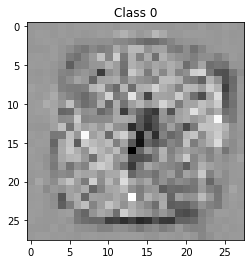

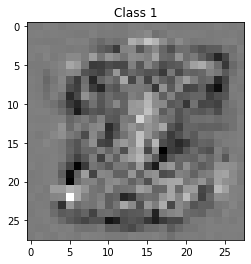

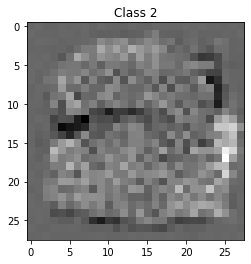

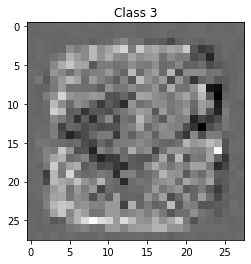

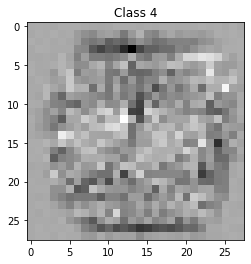

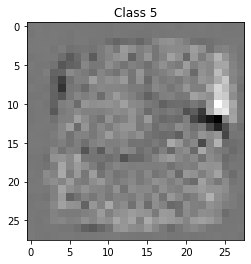

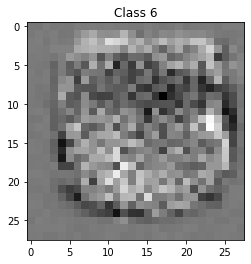

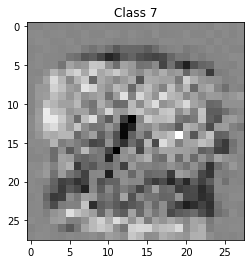

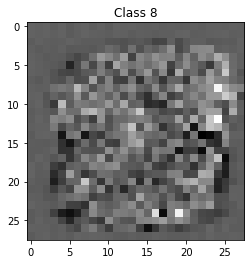

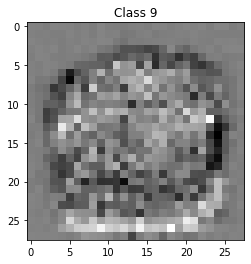

In [21]:
for parameter in network.parameters():
    for i in range(10):
        temp = torchvision.utils.make_grid(parameter[i].resize(28, 28))
        
        temp_np = temp.numpy()
        mx_val = np.amax(temp_np)
        mn_val = np.amin(temp_np)
        
        temp_np -= mn_val
        
        temp_np /= (mx_val - mn_val)
        
        plt.figure()
        plt.title("Class " + str(i))
        plt.imshow(np.transpose(temp_np, (1, 2, 0)))
        plt.show()
    
    break # we only need the first model parameter (weights)

In [22]:
limited_net = Net(num_inputs, num_outputs)
limited_optimizer = optim.SGD(limited_net.parameters(), lr=lr)
# train only on 50 examples

def limited_train(epoch, train_loader):
    limited_net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx >= 50:
            break
            
        data, target = Variable(data), Variable(target)
        limited_optimizer.zero_grad()
        output = limited_net(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        limited_optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def limited_test(test_loader):
    limited_net.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = limited_net(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [23]:
# we shall use the same options

for i in range(1, epochs+1):
    limited_train(i, mnist_train_loader)

limited_test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.437401
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.864341
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.613414
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.444835
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.523172
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.401522
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.489282
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.404902
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.512106
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.369641

Test set: Average loss: 0.3719, Accuracy: 8993/10000 (90%)



# **Answer (3):**
create needed blocks of code (and results) below

In [24]:
def temp_train(epoch, train_loader):
    '''Trains the data and returns the loss mean for the current epoch'''
    network.train()
    
    loss_epoch = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        loss_epoch.append(loss.item())
        
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    loss_mean_epoch = np.mean(loss_epoch)
    return loss_mean_epoch

In [25]:
class MultiLayerNet(nn.Module):
    '''Class for the required CNN in Q3 containing a new hidden layer with 1000 units in it'''
    
    def __init__(self, num_inputs, num_outputs):
        super(MultiLayerNet, self).__init__()
        self.linear1 = nn.Linear(num_inputs, 1000)
        self.linear2 = nn.Linear(1000, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs)
        x = self.linear1(x)
        x = self.linear2(x)
        x = torch.tanh(x)
        return x

In [26]:
lr = 0.01

train_loss_curves = [[], [], [], []]

for i in range(4):
    print("Learning Rate: " + str(lr), end=2*'\n')
    
    network = MultiLayerNet(28 ** 2, 10)
    optimizer = optim.SGD(network.parameters(), lr=lr)
    
    # training the new model with the current learning rate
    
    for j in range(1, epochs+1):
        curr_loss_avg = temp_train(j, mnist_train_loader)
        train_loss_curves[i].append(curr_loss_avg)

    test(mnist_test_loader)
    
    lr *= 10 # updating the learning rate

Learning Rate: 0.01

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.219516
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.346127
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.199516
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.216691
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.071004
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.022906
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.085679
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.048754
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.087719
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.078574
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.103361
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.001055
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.010359
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.029939
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.965483
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.004561
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.977110
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.964212
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.121333
Train Epoch: 2 [57600/60000 (96%)]	Loss: 

Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.966290
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.971970
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.966490
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.952840
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.966039
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.012062
Train Epoch: 8 [0/60000 (0%)]	Loss: 1.002116
Train Epoch: 8 [6400/60000 (11%)]	Loss: 1.002998
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.935414
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.927057
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.920962
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.883910
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.936856
Train Epoch: 8 [44800/60000 (75%)]	Loss: 1.078297
Train Epoch: 8 [51200/60000 (85%)]	Loss: 1.079727
Train Epoch: 8 [57600/60000 (96%)]	Loss: 1.019004
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.951690
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.944985
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.940148
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.974371
Train Epoch:

Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.844550
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.750800
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.844550
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.657050
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.625800
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.719550
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.688300
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.688300
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.657050
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.563300
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.813300
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.782050
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.625800
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.782050
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.907050
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.938300
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.782050
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.750800
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.500800
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.657050
Train Epoch:

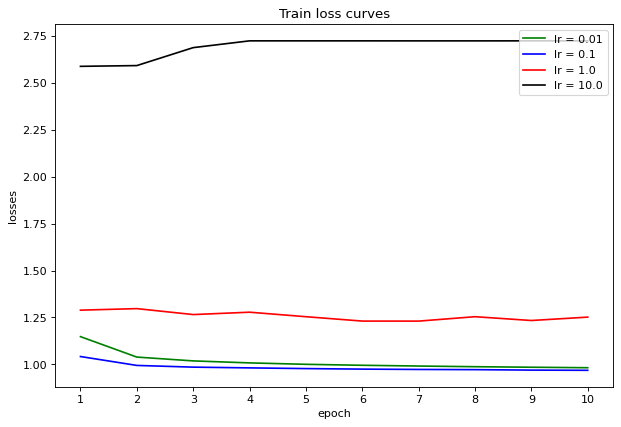

In [27]:
# plotting the loss curves for all four learning rates

colors = ['green', 'blue', 'red', 'black'] # the colors used for different lr in the plot

fg = plt.figure(figsize=(9, 6), dpi=80)
ax = fg.gca()

curr_lr = 0.01

for i in range(4):
    ax.plot(range(1, len(train_loss_curves[i]) + 1), train_loss_curves[i], '-', color=colors[i], label='lr = ' + str(curr_lr))
    curr_lr *= 10

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
plt.title('Train loss curves')

plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(loc="upper right")

plt.show()

# **Answer (4):**
create needed blocks of code (and results) below

In [28]:
dataset = 'cifar10'
lr = 0.01

In [29]:
class ConvNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels=1):
        super(ConvNet, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(num_inputs * num_channels, 16, 5, stride=2)
        self.conv2 = nn.Conv2d(16, 64, 3, stride=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        
        # linear layers
        self.linear1 = nn.Linear(1600, 64)
        self.linear2 = nn.Linear(64, num_outputs)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.conv3(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x

In [30]:
epochs = 20
network = ConvNet(num_inputs=1, num_outputs=10, num_channels=3)
optimizer = optim.SGD(network.parameters(), lr=lr)
train_loss_curve = []

# train the new model and save the loss in the above list for the plot

for i in range(1, epochs+1):
    curr_loss_avg = temp_train(i, cifar_train_loader)
    train_loss_curve.append(curr_loss_avg)
    
test(cifar_test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.300968
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.239878
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.106543
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.077906
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.033564
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.974578
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.922707
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.877892
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.973104
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.951729
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.871061
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.795072
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.027941
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.780785
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.851488
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.951426
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.831050
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.683702
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.822901
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.629005
Train Epoch: 3 [25

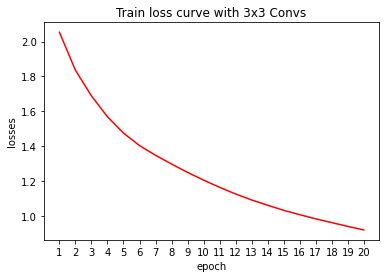

In [31]:
# plotting the loss curve for the training set

fg = plt.figure()
ax = fg.gca()
ax.plot(range(1, len(train_loss_curve) + 1), train_loss_curve, '-', color='red')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train loss curve with 3x3 Convs')

plt.show()

In [32]:
class ConvNetWithout3(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels=1):
        super(ConvNetWithout3, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(num_inputs * num_channels, 16, 5, stride=2)
        
        # linear layers
        self.linear1 = nn.Linear(784, 64)
        self.linear2 = nn.Linear(64, num_outputs)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x

In [33]:
epochs = 20
network = ConvNetWithout3(num_inputs=1, num_outputs=10, num_channels=3)
optimizer = optim.SGD(network.parameters(), lr=lr)
train_loss_curve = []

# train the new model and save the loss in the above list for the plot

for i in range(1, epochs+1):
    curr_loss_avg = temp_train(i, cifar_train_loader)
    train_loss_curve.append(curr_loss_avg)
    
test(cifar_test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.337446
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.185729
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.124773
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.991563
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.917325
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.923393
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.036580
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.923822
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.712404
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.896944
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.887292
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.924137
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.812364
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.792955
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.741017
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.695773
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.664949
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.752300
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.572355
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.617517
Train Epoch: 3 [25

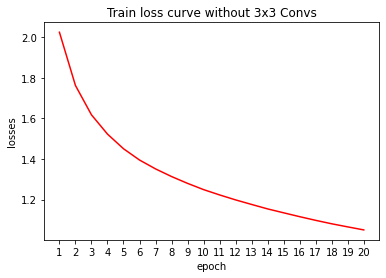

In [34]:
# plotting the loss curve for the training set

fg = plt.figure()
ax = fg.gca()
ax.plot(range(1, len(train_loss_curve) + 1), train_loss_curve, '-', color='red')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train loss curve without 3x3 Convs')

plt.show()